# Hotel Reservations

## Overview

## Business Understanding

With the ease of booking and canceling hotel reservations online, hotel cancelations and no-shows have drastically increased. This poses a significant problem for hotel revenue. Hotels are losing out on money when there are vacant rooms due to last minute cancellations. To combat this issue, I am going to create a model that can predict when a customer is going to cancel their reservation. This will allow the hotel to overbook an appropriate number of rooms so that they are not losing out on money due to vacant rooms while also not booking more rooms than there is space for in the hotel.

The stakeholders for this project are the hotel employees in charge of hotel bookings and operations, including the Reservations Manager, VP of Operations and, and VP of Revenue Management.

This business problem is important to the stakeholders because it is crucial to increase revenue coming from hotel room bookings. Additionally, they need to accurately manage vacancies for guests, which also impact the price of the rooms.

In order to solve this business problem, I will investigate the following 3 questions:
1. What factors contribute to **hotel cancellations**?
2. What factors contribute to **maintaining a hotel reservation**?
3. How can hotels strategically price rooms to **increase revenue**?

## Data Understanding

The [Hotel Reservations Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) extracted from Kaggle contains 36,275 entries of unique bookings ranging from 2017 to 2018. 

There are 19 columns, which are provided in the following data dictionary:

**Data Dictionary**

**Booking_ID**: unique identifier of each booking <br>
**no_of_adults**: Number of adults <br>
**no_of_children**: Number of Children <br>
**no_of_weekend_nights**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel <br>
**no_of_week_nights**: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel <br>
**type_of_meal_plan**: Type of meal plan booked by the customer <br>
**required_car_parking_space**: Does the customer require a car parking space? (0 - No, 1- Yes)<br>
**room_type_reserved**: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels. <br>
**lead_time**: Number of days between the date of booking and the arrival date <br>
**arrival_year**: Year of arrival date <br>
**arrival_month**: Month of arrival date <br>
**arrival_date**: Date of the month <br>
**market_segment_type**: Market segment designation <br>
**repeated_guest**: Is the customer a repeated guest? (0 - No, 1- Yes) <br>
**no_of_previous_cancellations**: Number of previous bookings that were canceled by the customer prior to the current booking <br>
**no_of_previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking <br>
**avg_price_per_room**: Average price per day of the reservation; prices of the rooms are dynamic. (in euros) <br>
**no_of_special_requests**: Total number of special requests made by the customer (e.g. high floor, view from the room, etc) <br>
**booking_status**: Flag indicating if the booking was canceled or not <br>

The target variable will be `booking_status`.

First, I must import necessary libraries that I will use for the EDA and data preparation.

In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

pd.options.mode.copy_on_write = True

# Suppress harmless warning for use_inf_as_na
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

Next I will load the dataset into the notebook.

In [2]:
data = pd.read_csv('data/hotel_reservations.csv')

## Data Preparation

### Data Cleaning

In [3]:
# Preview the first 5 rows of the train data
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
# View the overall shape, dtypes and null counts for each column in train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
# Check if there are any duplicates in the train data
data.duplicated(subset='Booking_ID').value_counts()

False    36275
Name: count, dtype: int64

There are no null values in the dataset. `repeated_guest` is of type integer but seems to be categorical, with 0 corresponsing to not a repeated guest and 1 corresponding to a repeated guest. 

In fact, our **categorical variables** are as follows: `type_of_meal_plan`, `required_car_parking_space`, `room_type_reserved`, `market_segment_type`, and `repeated_guest`. 

Our **quantitative variables** are `no_of_adults`, `no_of_children`, `no_of_weekend_nights`, `no_of_week_nights`, `lead_time`, `arrival_year`, `arrival_month`, `arrival_date`, `no_of_previous_cancellations`, `no_of_previous_bookings_not_canceled`, `avg_price_per_room`, and `no_of_special_requests`.

I will investigate the relationship between these features and the target, `booking_status`, to build a model that will predict whether a customer will cancel their reservation or not.

I am not using `Booking_ID` as a variable, as its purpose is just to confirm that each entry is a unique booking.

In [6]:
# Generate descriptive statistics of numerical variables in the data
data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


I will convert the values in `booking_status` to 1 for 'Canceled' and 0 for 'Not_Canceled.'

In [7]:
# Convert values in the target column to 0's and 1's
data['booking_status'] = data['booking_status'].map({'Canceled': 1,
                                                       'Not_Canceled': 0})

# Confirm it has been done correctly
data['booking_status'].value_counts()

booking_status
0    24390
1    11885
Name: count, dtype: int64

I will now convert the rest of the variables with string variables to numerical variables. This will prepare my data for One Hot Encoding.

In [8]:
# Check how many value types are in each variable with string values
print(data['type_of_meal_plan'].value_counts())
print('\n')

print(data['room_type_reserved'].value_counts())
print('\n')

print(data['market_segment_type'].value_counts())

type_of_meal_plan
Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: count, dtype: int64


room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64


market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64


In [9]:
# Convert values in the type_of_meal_plan to numerical values
data['type_of_meal_plan'] = data['type_of_meal_plan'].map({'Not Selected': 0,
                                                             'Meal Plan 1': 1,
                                                             'Meal Plan 2': 2,
                                                             'Meal Plan 3': 3})

# Convert values in the room_type_reserved to numerical values
data['room_type_reserved'] = data['room_type_reserved'].map({'Room_Type 1': 1,
                                                             'Room_Type 2': 2,
                                                             'Room_Type 3': 3,
                                                             'Room_Type 4': 4,
                                                             'Room_Type 5': 5,
                                                             'Room_Type 6': 6,
                                                             'Room_Type 7': 7})


# Convert values in the market_segment_type to numerical values
data['market_segment_type'] = data['market_segment_type'].map({'Offline': 0,
                                                             'Online': 1,
                                                             'Corporate': 2,
                                                             'Complementary': 3,
                                                             'Aviation': 4})

### Data Transformation

Before transforming any data, I will use `train_test_split` to split my data into a train set and a test set. This is to prevent data leakage. When I test my model on the test set, I want it to mimic unknown data as best as possible. 

In [10]:
# Split dataset into features and target

X = data.drop(columns=['booking_status', 'Booking_ID'], axis = 1)
y = data['booking_status']

In [11]:
# Split the data into a train set and a test set using default values where 75% of the data is train and the remaining
# 25% is the test data
# Random state used for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=28)

Next, I will use `OneHotEncoder` on my categorical variables with no ordinal relationship

In [12]:
# Create dummy variables for categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Create dataframe with only the columns that require One Hot Encoding
categorical_train = X_train[['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                          'market_segment_type', 'repeated_guest']].copy()

categorical_test = X_test[['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                          'market_segment_type', 'repeated_guest']].copy()

# Fit the encoder on the training data and transform it
ohe.fit_transform(categorical_train)

# Transform the test data
ohe.transform(categorical_test)

# Create new dataframes with One Hot Encoded columns
categorical_train_ohe = pd.DataFrame(data=ohe.transform(categorical_train),
                                    columns=ohe.get_feature_names_out(),
                                    index=categorical_train.index)

categorical_test_ohe = pd.DataFrame(data=ohe.transform(categorical_test),
                                   columns=ohe.get_feature_names_out(),
                                   index=categorical_test.index)

Now, I will use `StandardScaler` to standardize the quantitative features.

In [13]:
# Initialize the scaler
scaler = StandardScaler()

# Create dataframe with only quantitative variables
quant_train = X_train[['arrival_year', 'arrival_month', 'arrival_date','no_of_adults', 'no_of_children', 
                   'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']].copy()

quant_test = X_test[['arrival_year', 'arrival_month', 'arrival_date','no_of_adults', 'no_of_children', 
                   'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']].copy()

# Fit and transform the train data
scaler.fit_transform(quant_train)

# Transform the test data
scaler.transform(quant_test)

# Create new dataframes with Scaler columns
quant_train_scaler = pd.DataFrame(data=scaler.transform(quant_train),
                                  columns=quant_train.columns,
                                  index=quant_train.index)

quant_test_scaler = pd.DataFrame(data=scaler.transform(quant_test),
                                  columns=quant_test.columns,
                                  index=quant_test.index)

In [40]:
# Append one hot encoded data back to dataframe
X_train_transformed = pd.concat([quant_train_scaler, categorical_train_ohe], axis=1)

X_test_transformed = pd.concat([quant_test_scaler, categorical_test_ohe], axis=1)

# Preview new dataframe
X_train_transformed.head()

,arrival_year,arrival_month,arrival_date,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,room_type_reserved_7,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_1
2947,0.46805,-0.136897,-0.642154,0.298216,2.20181,0.218603,-1.550369,-0.991105,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3033,0.46805,-1.758329,1.423318,-1.635357,-0.26098,1.363639,-0.847614,-0.979430,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30081,0.46805,0.835962,-1.101148,0.298216,4.66460,-0.926433,-0.847614,0.304761,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21861,0.46805,-1.434042,-1.330645,0.298216,-0.26098,1.363639,-0.144860,-0.664220,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11680,0.46805,0.835962,-0.986400,0.298216,-0.26098,-0.926433,-0.144860,-0.827662,-0.062816,-0.086268,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Modeling

### Baseline Understanding

### First Model

I am going to create a baseline decision tree and evaluate the performance. As expected, the baseine model overfit the data. 

In [41]:
# Instantiate classifier and fit it to the training data
classifier = DecisionTreeClassifier(criterion='entropy', random_state=28)

classifier.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=28)

In [42]:
# Make predictions for train data
y_pred_train = classifier.predict(X_train_transformed)

# Make predictions for test data
y_pred_test = classifier.predict(X_test_transformed)

Accuracy is :99.4118944350511

Precision is :99.50935645823826

AUC is :0.99

Confusion Matrix
----------------


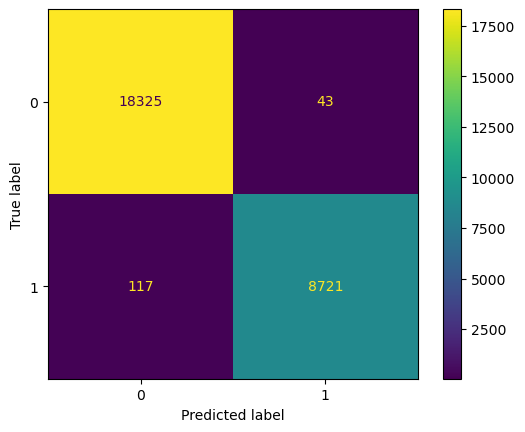

In [75]:
# Evaluate tree for train data

# Calculate accuracy 
acc = accuracy_score(y_train,y_pred_train) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_train,y_pred_train) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_train = confusion_matrix(y_train, y_pred_train)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                      display_labels=classifier.classes_)
cm_train_disp.plot();

Accuracy is :87.38559929429927

Precision is :81.24794745484401

AUC is :0.86

Confusion Matrix
----------------


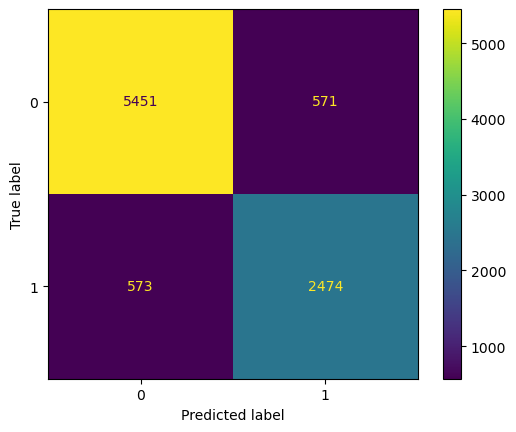

In [76]:
# Evaluate tree for test data

# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_test) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred_test) * 100
print('\nPrecision is :{0}'.format(prec))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_test = confusion_matrix(y_test, y_pred_test)

cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=classifier.classes_)
cm_test_disp.plot();

The baseline model performed better on the test data than I had anticipated. It produced an accuracy score of 87% and an AUC of 0.86. I do want to create a model that will produce a much better precision score, however, because 81% is quite low given our goal. We want to determine how many rooms the hotel can oversell, given the prediction of cancellations. The hotel does not want to oversell rooms and end up without space for guests and having to cancel their reservations.

In this case, false negatives are better than false positive. A false positive would be predicting that a hotel guest will cancel their reservation, but they end of keeping it. A false negative would be predicting that a hotel guest will keep their reservation but they end up canceling it. We want to avoid false positives becuase that will lead to the hotel overselling too many rooms and not having enough rooms for the number of guests who kept their room reservations.

### Modeling Iterations

### Final Model

## Conclusions